In [1]:
# Download image to tokenize
#!wget https://upload.wikimedia.org/wikipedia/en/e/ed/Nyan_cat_250px_frame.PNG -O to_tokenize.PNG

In [2]:
# !pip install patchify
# !pip install ipyplot

In [3]:
from PIL import Image
import torchvision
import torch
import patchify

torch.Size([3, 224, 224])


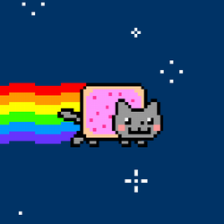

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Resize((224, 224))
])

to_pil_image = torchvision.transforms.ToPILImage()

to_tokenize = Image.open("to_tokenize.PNG")

transformed_pictures = transform(to_tokenize)

print(transformed_pictures.shape)
display(to_pil_image(transformed_pictures))

In [5]:
from typing import Tuple


def patchify_tensor(image_tensor: torch.Tensor, patch_size: Tuple[int, int]) -> torch.Tensor:
    patches = patchify.patchify(image_tensor.numpy(), (3, *patch_size), step=patch_size[0]) 
    return list(torch.Tensor(patches).reshape(patches.shape[1] * patches.shape[2], *patches.shape[3::]).type(image_tensor.dtype))

patches = patchify_tensor(transformed_pictures, [32, 32])

/home/paul/workspaces/PycharmProjects/practical_pytorch_dl/venv/lib/python3.10/site-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



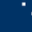
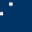
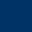
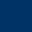
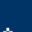
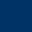
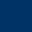
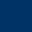
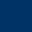
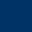
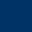
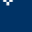
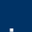
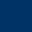
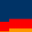
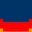
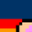
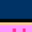
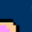
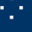
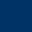
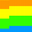
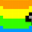
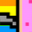
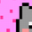
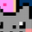
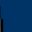
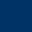
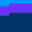
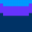
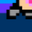
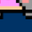
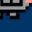
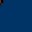
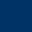
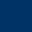
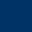
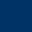
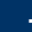
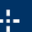
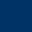
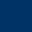
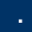
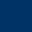
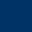
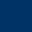
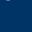
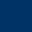
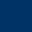


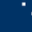
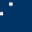
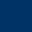
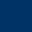
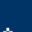
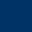
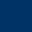
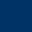
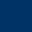
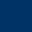
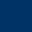
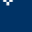
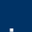
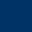
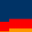
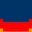
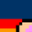
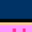
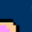
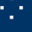
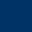
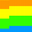
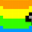
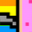
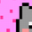
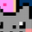
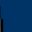
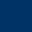
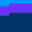
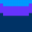
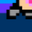
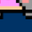
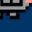
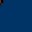
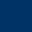
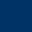
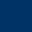
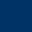
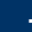
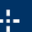
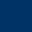
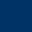
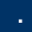
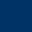
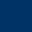
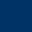
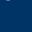
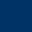
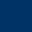

In [6]:
import ipyplot

ipyplot.plot_images([to_pil_image(patch) for patch in patches], max_images=len(patches), img_width=170, zoom_scale=1)

# Create a torch Layer

In [7]:
import functools
from typing import Tuple


class ImageEmbeddingLayer(torch.nn.Module):
    def __init__(self, patch_sizes:Tuple[int, int], output_features:int, image_shape: Tuple[int, int, int]) -> None:
        super().__init__()
        # make sure image shape and patch_size match
        assert image_shape[1] % patch_sizes[0] == 0 
        assert image_shape[2] % patch_sizes[1] == 0 
        # make sure output features and number of patches match
        self.num_patches =  int((image_shape[1] / patch_sizes[0]) * (image_shape[2] / patch_sizes[1]))

        self.patch_size = patch_sizes
        self.image_shape = image_shape
        self.output_features = output_features

        self.patch_function = functools.partial(patchify_tensor, patch_size=patch_sizes)
        in_features = int(3 * patch_sizes[0] * patch_sizes[1])
        print(in_features, output_features)
        print(self.num_patches)
        self.embedding_layer = torch.nn.Linear(in_features=in_features, out_features=output_features) 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        patches = self.patch_function(x)
        outputs = [self.embedding_layer(patch.flatten()) for patch in patches]
        return torch.cat(outputs)
        


In [8]:
input_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
input_image = (input_transform(to_tokenize))

In [9]:
layer = ImageEmbeddingLayer((16, 16), output_features=4, image_shape=(3, 224, 224))
output = layer(input_image)
output.shape

768 4
196


torch.Size([784])

In [10]:
56 ** 2 * 3

9408